In [3]:
# Moving to project directory
%cd /home/ayush12gupta/Desktop/ugp/exp2/

/home/ayush12gupta/Desktop/ugp/exp2


In [4]:
from osgeo import gdal, osr
import numpy as np
import os
import netCDF4

In previous step, we did feature tracking using autoRIFT, it gives following files as output:-
 * "offset.tif"       This file contains the geographic displacements in X and Y directions     
 * "velocity.tif"     This file contains the velocity in X and Y directions in two seperate bands 
 * NetCDF file        This contains all the metadata and velocities as well as projs and transformation
 
We use *velocity.tif* or *offset.tif* for obtaining the exact bounding box of our target region in geographic coordinates (UTM projection in this case), and resample DEM for that bounding box region so that we have consistent matrix sizes, when we compute terrain slopes for computation of velocity in flow and thickness direction

In [16]:
# NetCDF file generated from autoRIFT step
file2read = netCDF4.Dataset('exp_nc_G0028V02_P095.nc','r')
print(file2read.variables.keys())
print(file2read.variables['img_pair_info'])

odict_keys(['img_pair_info', 'x', 'y', 'mapping', 'vx', 'vy', 'v', 'v_error', 'vr', 'va', 'M11', 'M12', 'chip_size_width', 'chip_size_height', 'interp_mask'])
<class 'netCDF4._netCDF4.Variable'>
vlen img_pair_info()
    mission_img1: S
    sensor_img1: C
    satellite_img1: 1A
    acquisition_img1: 20190701T12:56:28.026977
    time_standard_img1: UTC
    absolute_orbit_number_img1: 027924
    mission_data_take_ID_img1: 03271C
    product_unique_ID_img1: 0046
    flight_direction_img1: ascending
    mission_img2: S
    sensor_img2: C
    satellite_img2: 1A
    acquisition_img2: 20190713T12:56:28.737528
    time_standard_img2: UTC
    absolute_orbit_number_img2: 028099
    mission_data_take_ID_img2: 032C6A
    product_unique_ID_img2: 869A
    flight_direction_img2: ascending
    date_dt: 12.000008223969907
    date_center: 20190707T12:56:28.382253
    latitude: 32.3
    longitude: 76.73
    roi_valid_percentage: 95.3
    autoRIFT_software_version: 1.4.0
vlen data type: <class 'str'>
unli

In [17]:
# Cropping DEM to generate matrix of exact size as that of velocity matrix outputs
def get_size(filenm):
    ds = gdal.Open(filenm)
    demsp = ds.GetRasterBand(1).ReadAsArray()
    x_size, y_size = demsp.shape[::-1]
    return (x_size, y_size)

#-------------Get bbox ------------------------
def getbbox(filenm):
    ds = gdal.Open(filenm)
    geo = ds.GetGeoTransform()
    demsp = ds.GetRasterBand(1).ReadAsArray()
    x_size, y_size = demsp.shape[::-1]
    geo_t = np.array(geo).copy()
    xmin = min(geo_t[0], geo_t[0] + x_size * geo_t[1])
    xmax = max(geo_t[0], geo_t[0] + x_size * geo_t[1])
    ymin = min(geo_t[3], geo_t[3] + y_size * geo_t[5])
    ymax = max(geo_t[3], geo_t[3] + y_size * geo_t[5])
    return [xmin, ymin, xmax, ymax]

bbox = getbbox('velocity.tif')
input_dem = "../slope_demroi2.tif" # Specify the DEM path which is in UTM proj
outpath = "dem_test.tif"
cmd = "gdalwarp -te {0} {1} {2} {3} {4} {5}".format(*bbox, input_dem, outpath)
os.system(cmd)
print("Matrix size of velocity.tif: ", get_size("velocity.tif"))
print("Matrix size of generated dem_test.tif: ", get_size("dem_test.tif"))

Matrix size of velocity.tif:  (3106, 2870)
Matrix size of generated dem_test.tif:  (3106, 2870)


Process the DEM file generated above to get the slope map using "*Slope*" plugin of QGIS, or you can calculate slopes in X and Y directions seperately and just take their resultant.

In [18]:
#-----Params for velocity processing----------------
incidenceAngle = 41.88  # Assuming incidenceAngle to be constant due to small target region
deg2rad = np.pi/180
sin_incid = np.sin(incidenceAngle*deg2rad)
cos_incid = np.cos(incidenceAngle*deg2rad)

#----------- Angle u-----------------------
"""
As its the spherical angle between the vertical and local surface normal.
We obtain it simply using the Slope plugin of QGIS
"""
demsp = gdal.Open('slope_dem.tif')    # Obtained on processing dem_test.tif using Slope plugin
projs = demsp.GetProjection()
geo = demsp.GetGeoTransform()
nodata = demsp.GetRasterBand(1).GetNoDataValue()
angle_u = demsp.GetRasterBand(1).ReadAsArray()*deg2rad
angle_u_nodt = (angle_u==nodata)
demsp = None

#----------- Compute angle V------------------------
"""
As its the spherical angle between the azimuth and the projection of the local surface
normal on to the horizontal. So we take the resultant of velocity in range and azimuth
direction, and take the projection of resultant X-Y plane
"""
vr = np.array(file2read['vr']).astype(float)
vr_nodt = (vr==-32767)    # Handling nodata points
vr[vr_nodt] = 0  #np.nan
va = np.array(file2read['va']).astype(float)

va_nodt = (va==-32767)    # Handling nodata points
va[va_nodt] = 0  #np.nan

nodata = (va!=0)
tmp = np.zeros_like(vr)
tmp[nodata] = (vr*sin_incid)[nodata]/va[nodata]
angle_v = np.arctan(tmp)

### Computing Velocity in Flow and Normal Directions
[<img src="./figures/directions.png" width="450"/>](./figures/directions.png)
![](./code/figures/formula.png)

where,  

        F is displacement of glaciers along flow direction,

        T is glacier thickness change, 

        θ is the local incidence angle,

        δR is the glacier LOS displacement, 

        δAZ is the glacier along-track displacement,

In [19]:
#--------------Flow velocity along the glacier plane--------------------
vf = vr*(((np.cos(angle_u)* np.sin(angle_v))*sin_incid) - (cos_incid*np.sin(angle_u))) + va*(np.cos(angle_u)*np.cos(angle_v))
vf[angle_u_nodt] = 0
vf[va_nodt] = -32767     # Handling nodata points
vf[vr_nodt] = -32767     # Handling nodata points

In [20]:
#------------Thickness change velocity------------------------
vn = vr*(((np.sin(angle_u)* np.sin(angle_v))*sin_incid) - (cos_incid*np.cos(angle_u))) + va*(np.sin(angle_u)*np.cos(angle_v))
vn[angle_u_nodt] = 0
vn[va_nodt] = -32767     # Handling nodata points
vn[vr_nodt] = -32767     # Handling nodata points

Saving the generated velocity in flow direction and normal direction to GTIFF file

In [25]:
# Functions for creating the raster in GTIFF format
GDAL_DATA_TYPE = gdal.GDT_Float64 
GEOTIFF_DRIVER_NAME = "GTiff"
NO_DATA = -32767
SPATIAL_REFERENCE_SYSTEM_WKID = 32767

def create_raster(output_path,
                  columns,
                  rows,
                  nband = 1,
                  gdal_data_type = GDAL_DATA_TYPE,
                  driver = GEOTIFF_DRIVER_NAME):

    driver = gdal.GetDriverByName(driver)

    output_raster = driver.Create(output_path, int(columns), int(rows), nband, eType = gdal_data_type)    
    return output_raster

def numpy_array_to_raster(output_path,
                          numpy_array,
                          proj,
                          trans,
                          nband = 1,
                          no_data = NO_DATA,
                          gdal_data_type = GDAL_DATA_TYPE,
                          spatial_reference_system_wkid = SPATIAL_REFERENCE_SYSTEM_WKID,
                          driver = GEOTIFF_DRIVER_NAME):


    rows, columns = numpy_array.shape
    output_raster = create_raster(output_path, int(columns), int(rows), nband, gdal_data_type) 
    geotransform = trans

    spatial_reference = osr.SpatialReference()
    spatial_reference.ImportFromWkt(proj)
    output_raster.SetProjection(spatial_reference.ExportToWkt())
    output_raster.SetGeoTransform(geotransform)
    output_band = output_raster.GetRasterBand(1)
    output_band.SetNoDataValue(no_data)
    output_band.WriteArray(numpy_array)          
    output_band.FlushCache()
    
    return  output_raster

def save_raster(filename, raster, projection, transforms):
    ds = numpy_array_to_raster(filename, raster, projection, transforms)
    ds.FlushCache()
    ds = None

In [26]:
# Saving flow and thickness change rates
save_raster("VN.tif", vn, projs, geo)
save_raster("VF.tif", vf, projs, geo)

### Visualising Flow and Thickness Change Velocities

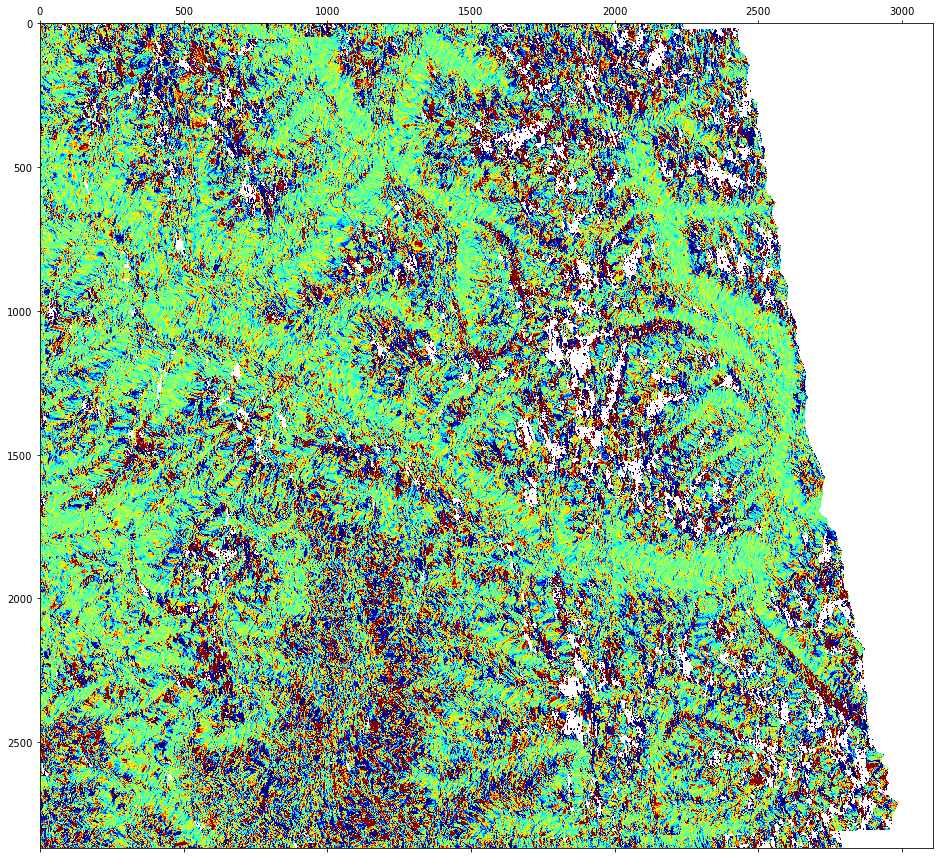

In [30]:
# Visualing velocity in flow direction 
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import math
vf[vf==-32767] = np.nan

plt.matshow(vf, cmap='jet', vmin=-100, vmax=100)  
plt.rcParams['figure.figsize'] = [1200, 800]
plt.show()

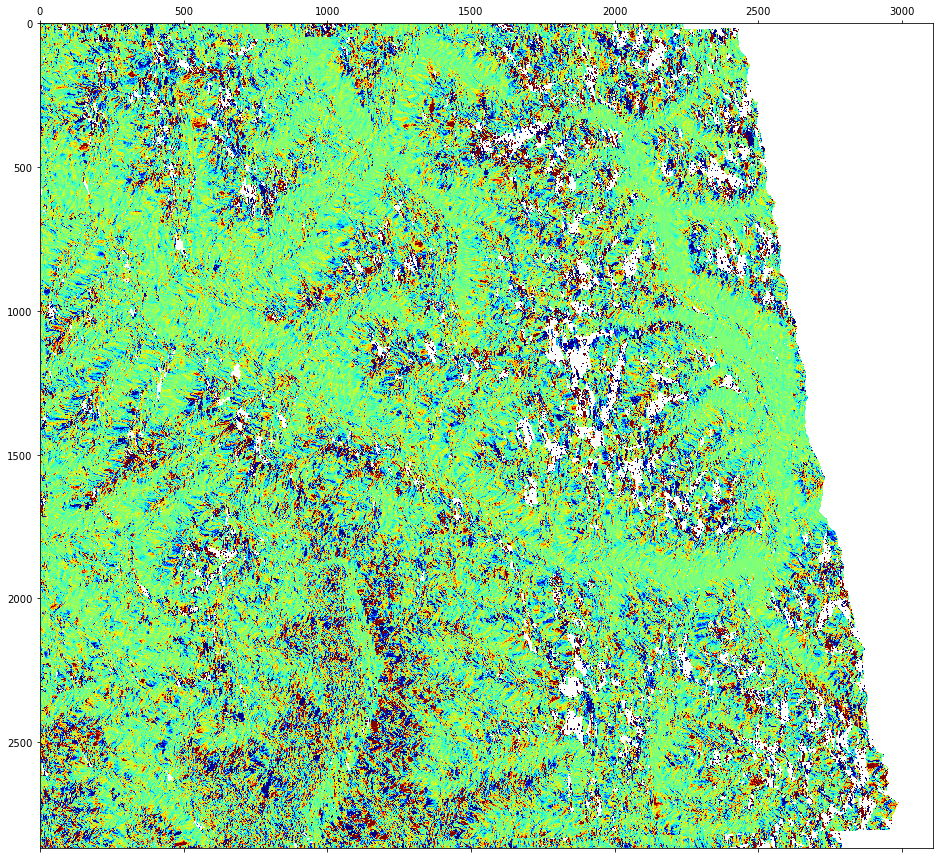

In [31]:
# Visualing rate of thickness change 
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import math
vn[vn==-32767] = np.nan

plt.matshow(vn, cmap='jet', vmin=-100, vmax=100)  
plt.rcParams['figure.figsize'] = [1200, 800]
plt.show()